In [ ]:
import os
import numpy as np
from keras.preprocessing.image import img_to_array, load_img
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
import argparse

In [ ]:

# os.makedirs('/content/drive/MyDrive/Trained Models')

In [ ]:
directory = '/content/drive/MyDrive/Train_Augmented'
noisy_dir = os.path.join(directory, 'low')
clean_dir = os.path.join(directory, 'high')

In [ ]:
all_file_names=os.listdir(noisy_dir)

In [ ]:
len(all_file_names)

1940

In [ ]:
all_file_names.sort()

In [ ]:
all_file_names

['10.png',
 '100.png',
 '100lr.png',
 '100rot.png',
 '100ud.png',
 '101.png',
 '101lr.png',
 '101rot.png',
 '101ud.png',
 '102.png',
 '102lr.png',
 '102rot.png',
 '102ud.png',
 '103.png',
 '103lr.png',
 '103rot.png',
 '103ud.png',
 '104.png',
 '104lr.png',
 '104rot.png',
 '104ud.png',
 '105.png',
 '105lr.png',
 '105rot.png',
 '105ud.png',
 '106.png',
 '106lr.png',
 '106rot.png',
 '106ud.png',
 '107.png',
 '107lr.png',
 '107rot.png',
 '107ud.png',
 '109.png',
 '109lr.png',
 '109rot.png',
 '109ud.png',
 '10lr.png',
 '10rot.png',
 '10ud.png',
 '110.png',
 '110lr.png',
 '110rot.png',
 '110ud.png',
 '112.png',
 '112lr.png',
 '112rot.png',
 '112ud.png',
 '113.png',
 '113lr.png',
 '113rot.png',
 '113ud.png',
 '114.png',
 '114lr.png',
 '114rot.png',
 '114ud.png',
 '115.png',
 '115lr.png',
 '115rot.png',
 '115ud.png',
 '116.png',
 '116lr.png',
 '116rot.png',
 '116ud.png',
 '117.png',
 '117lr.png',
 '117rot.png',
 '117ud.png',
 '118.png',
 '118lr.png',
 '118rot.png',
 '118ud.png',
 '119.png',
 '

In [ ]:
import random
random.seed(42)
train_filenames, test_filenames = train_test_split(all_file_names, test_size=0.2, random_state=42)

In [ ]:
# train_filenames.sort()

In [ ]:
# train_filenames,val_filenames=train_test_split(train_filenames,test_size=0.2,random_state=42)

In [ ]:
# val_filenames

In [ ]:
# val_size=len(val_filenames)
# val_size

In [ ]:
len(train_filenames)

1552

In [ ]:
def load_data(filenames, batch_size, noisy_dir, clean_dir, target_size=(256, 256)):
    while True:
        noisy_images = []
        clean_images = []
        np.random.shuffle(filenames)
        batch_filenames = np.random.choice(filenames, batch_size)
        for filename in batch_filenames:
            noisy_path = os.path.join(noisy_dir, filename)
            clean_path = os.path.join(clean_dir, filename)
            try:
                # Loading the images in target size
                noisy_image = load_img(noisy_path, target_size=target_size)
                clean_image = load_img(clean_path, target_size=target_size)

                # Converting to array
                noisy_array = img_to_array(noisy_image)
                clean_array = img_to_array(clean_image)

                noisy_array = noisy_array / 255.0
                clean_array = clean_array / 255.0

                noisy_images.append(noisy_array)
                clean_images.append(clean_array)
            except Exception as e:
                print(f"Error processing file {filename}: {e}")
                continue

        yield np.array(noisy_images), np.array(clean_images)

In [ ]:
train_generator = load_data(train_filenames,noisy_dir=noisy_dir,clean_dir=clean_dir,batch_size=24)
validation_generator = load_data(test_filenames,noisy_dir=noisy_dir,clean_dir=clean_dir,batch_size=24)

In [ ]:
noisy_batch, clean_batch = next(train_generator)
print("Noisy batch shape:", noisy_batch.shape)
print("Clean batch shape:", clean_batch.shape)

Noisy batch shape: (24, 256, 256, 3)
Clean batch shape: (24, 256, 256, 3)


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose,\
                                    GlobalAveragePooling2D, AveragePooling2D, MaxPool2D, UpSampling2D,\
                                    BatchNormalization, Activation, ReLU, Flatten, Dense, Input,\
                                    Add, Multiply, Concatenate, Softmax,Reshape,Dropout
from tensorflow.keras import initializers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import softmax
from tensorflow.keras.losses import MeanSquaredError
from keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.applications import VGG19
from tensorflow.image import ssim
tf.keras.backend.set_image_data_format('channels_last')
import keras.backend as K

#Creating The Convolutional Block Class

In [ ]:
@tf.keras.saving.register_keras_serializable()
class Conv_block(tf.keras.layers.Layer):
    def  __init__(self, num_filters=200, kernel_size=3,**kwargs):
        super().__init__(**kwargs)
        self.num_filters=num_filters
        self.kernel_size=kernel_size
        self.conv_1 = Conv2D(filters=self.num_filters, kernel_size=self.kernel_size, padding='same')
        self.conv_2 = Conv2D(filters=self.num_filters, kernel_size=self.kernel_size, padding='same')
        self.conv_3 = Conv2D(filters=self.num_filters, kernel_size=self.kernel_size, padding='same')
        self.conv_4 = Conv2D(filters=self.num_filters, kernel_size=self.kernel_size, padding='same')
        self.SE     = SEBlock(filters=self.num_filters)
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'num_filters': self.num_filters,
            'kernel_size':self.kernel_size
        })
        return config

    def call(self, X):
        X = self.conv_1(X)
        # X = self.bn_1(X)
        X = ReLU()(X)
        X = self.conv_2(X)
        # X = self.bn_2(X)
        X = ReLU()(X)
        X = self.conv_3(X)
        # X = self.bn_3(X)
        X = ReLU()(X)
        # X = self.conv_4(X)
        # # # X = self.bn_4(X)
        # X = ReLU()(X)
        X = self.SE(X)
        return X

In [ ]:
@tf.keras.saving.register_keras_serializable()
class SEBlock(tf.keras.layers.Layer):
    def __init__(self, filters, reduction=16, **kwargs):
        super(SEBlock, self).__init__(**kwargs)
        self.filters = filters
        self.reduction = reduction
        self.global_avg_pool = GlobalAveragePooling2D()
        self.reshape = Reshape((1, 1, filters))
        self.dense1 = Dense(filters // reduction, activation='relu', kernel_initializer='he_normal', use_bias=False)
        self.dense2 = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)

    def call(self, input_tensor):
        se = self.global_avg_pool(input_tensor)
        se = self.reshape(se)
        se = self.dense1(se)
        se = self.dense2(se)
        return Multiply()([input_tensor, se])

    def get_config(self):
        config = super(SEBlock, self).get_config()
        config.update({
            'filters': self.filters,
            'reduction': self.reduction
        })
        return config

#Function for Wavelet Transformation

In [ ]:
@tf.keras.saving.register_keras_serializable()
class DWT_downsampling(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, x):
        x1 = x[:, 0::2, 0::2, :] #x(2i−1, 2j−1)
        x2 = x[:, 1::2, 0::2, :] #x(2i, 2j-1)
        x3 = x[:, 0::2, 1::2, :] #x(2i−1, 2j)
        x4 = x[:, 1::2, 1::2, :] #x(2i, 2j)

        x_LL = x1 + x2 + x3 + x4
        x_LH = -x1 - x3 + x2 + x4
        x_HL = -x1 + x3 - x2 + x4
        x_HH = x1 - x3 - x2 + x4

        return Concatenate(axis=-1)([x_LL, x_LH, x_HL, x_HH])

      
        The following calculations for IWT and DWT are used from,
        https://github.com/AureliePeng/Keras-WaveletTransform/blob/master/models/DWT.py
        

In [ ]:
@tf.keras.saving.register_keras_serializable()
class IWT_upsampling(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, x):
        x_LL = x[:, :, :, 0:x.shape[3]//4]
        x_LH = x[:, :, :, x.shape[3]//4:x.shape[3]//4*2]
        x_HL = x[:, :, :, x.shape[3]//4*2:x.shape[3]//4*3]
        x_HH = x[:, :, :, x.shape[3]//4*3:]

        x1 = (x_LL - x_LH - x_HL + x_HH)/4
        x2 = (x_LL - x_LH + x_HL - x_HH)/4
        x3 = (x_LL + x_LH - x_HL - x_HH)/4
        x4 = (x_LL + x_LH + x_HL + x_HH)/4

        y1 = K.stack([x1,x3], axis=2)
        y2 = K.stack([x2,x4], axis=2)
        shape = K.shape(x)
        return K.reshape(K.concatenate([y1,y2], axis=-1), K.stack([shape[0], shape[1]*2, shape[2]*2, shape[3]//4]))

# Defining Model Architecture

In [ ]:
def create_model():
    tf.keras.backend.clear_session()

    input = Input(shape=(256,256,3))

    cb_1 = Conv_block(num_filters=64)(input)
    dwt_1 = DWT_downsampling()(cb_1)

    cb_2 = Conv_block(num_filters=128)(dwt_1)
    dwt_2 = DWT_downsampling()(cb_2)

    cb_3 = Conv_block(num_filters=256)(dwt_2)
    dwt_3 = DWT_downsampling()(cb_3)

    cb_4 = Conv_block(num_filters=512)(dwt_3)
    dwt_4 = DWT_downsampling()(cb_4)

    cb_5 = Conv_block(num_filters=512)(dwt_4)
    cb_5 = BatchNormalization()(cb_5)
    cb_5 = Conv_block(num_filters=512)(cb_5)
    cb_5 = Conv2D(filters=2048, kernel_size=3, strides=1, padding='same')(cb_5)

    up = IWT_upsampling()(cb_5)
    up = Conv_block(num_filters=512)(Add()([up, cb_4]))
    up = Conv2D(filters=1024, kernel_size=3, strides=1, padding='same')(up)

    up = IWT_upsampling()(up)
    up = Conv_block(num_filters=256)(Add()([up, cb_3]))
    up = Conv2D(filters=512, kernel_size=3, strides=1, padding='same')(up)

    up = IWT_upsampling()(up)
    up = Conv_block(num_filters=128)(Add()([up, cb_2]))
    up = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(up)

    up = IWT_upsampling()(up)
    up = Conv_block(num_filters=64)(Add()([up, cb_1]))
    up = Conv2D(filters=128, kernel_size=3, strides=1, padding='same')(up)

    out = Conv2D(filters=3, kernel_size=(1, 1), padding="same")(up)
    model=Model(inputs=[input],outputs=[out])
    return model

In [ ]:
# Creating the MWCNN model
model = create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv_block (Conv_block)     (None, 256, 256, 64)         76160     ['input_1[0][0]']             
                                                                                                  
 dwt_downsampling (DWT_down  (None, 128, 128, 256)        0         ['conv_block[0][0]']          
 sampling)                                                                                        
                                                                                                  
 conv_block_1 (Conv_block)   (None, 128, 128, 128)        592256    ['dwt_downsampling[0][0]']

In [ ]:
from tensorflow.keras.utils import plot_model

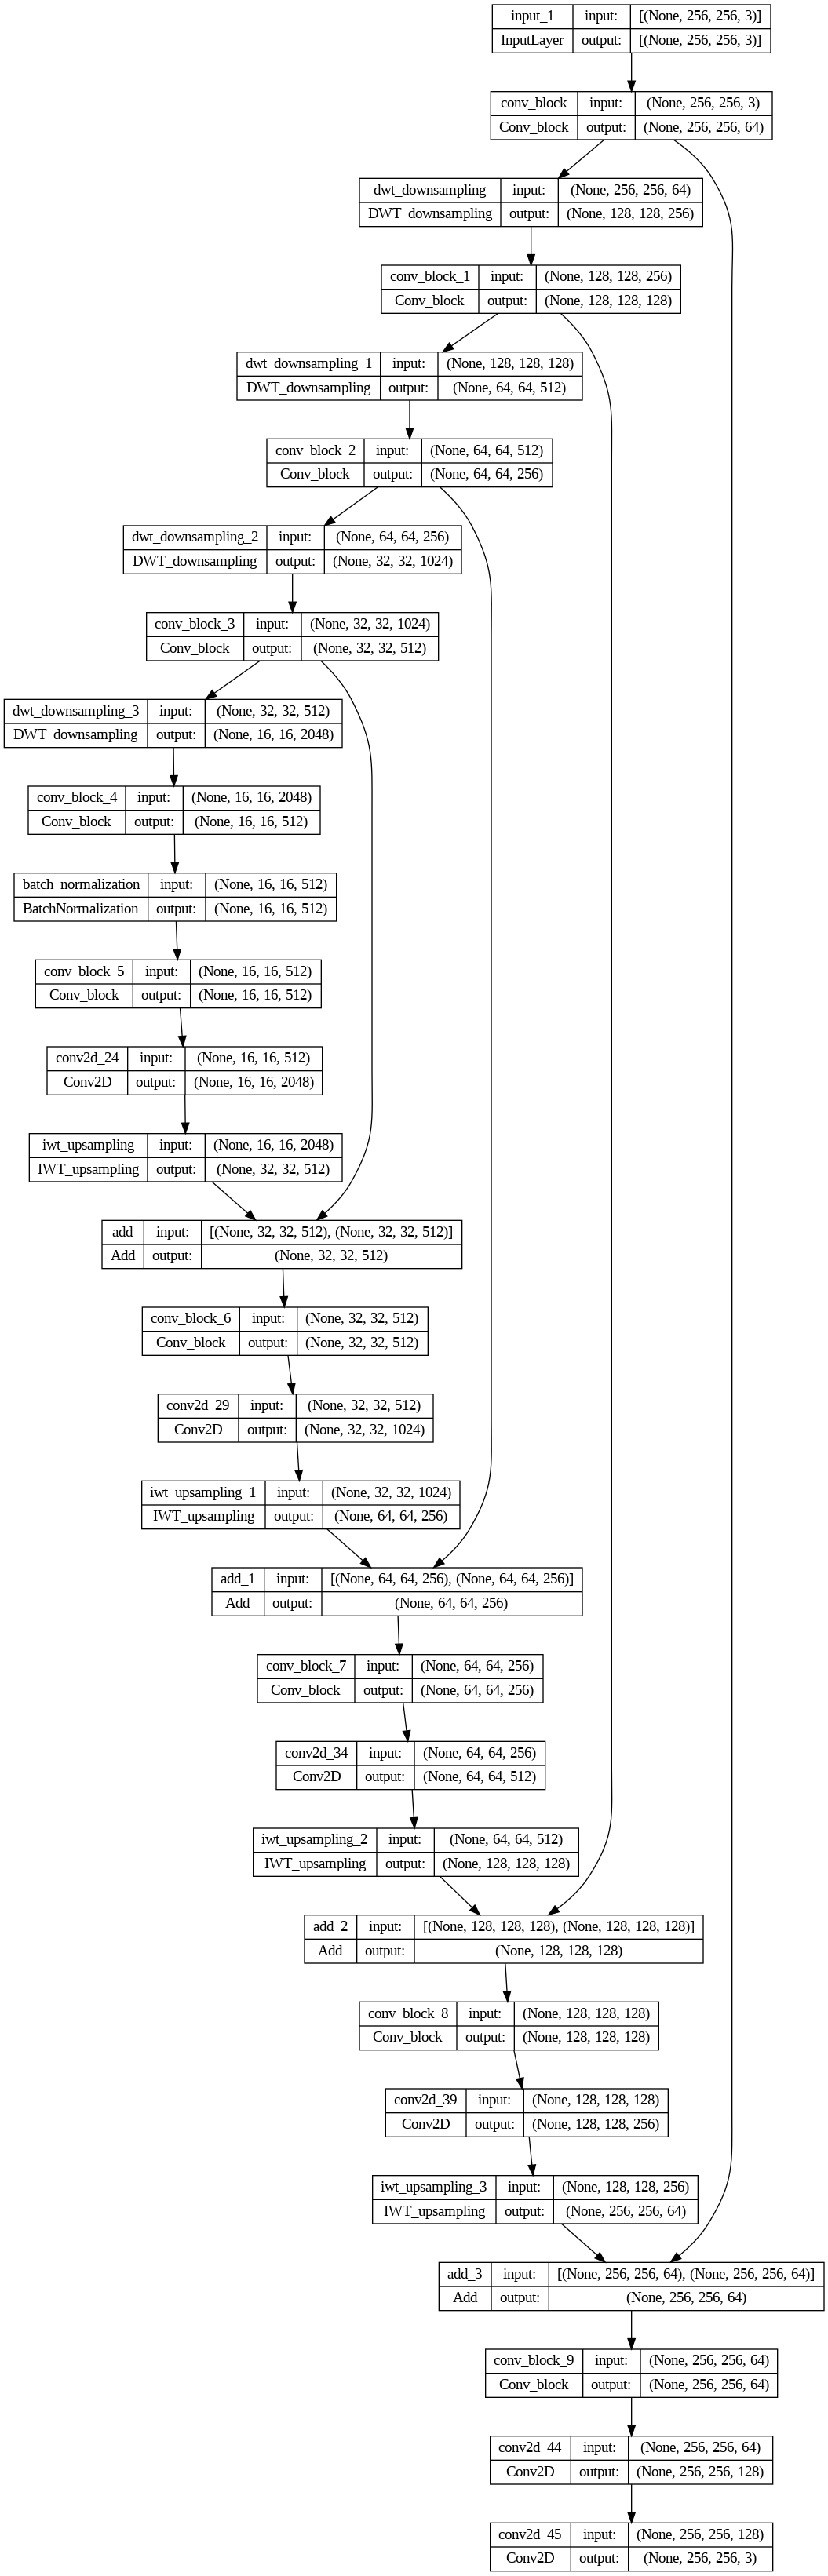

In [ ]:
plot_model(model,show_shapes=True,to_file='model.png' ,show_layer_names=True)

#Defining Callbacks

In [ ]:
best_models_path = "/content/drive/MyDrive/Trained_Model/"
callbacks_lst = [
    tf.keras.callbacks.ModelCheckpoint(filepath=best_models_path+"Final_MWCNN_Checkpoint_1.h5",
                                        monitor='val_loss',
                                        mode='min',
                                        save_best_only=True,
                                        save_freq='epoch',
                                        verbose=1
                                       ),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_lr=0.0000009, min_delta=0.0001, factor=0.67, patience=2, verbose=1, mode='min'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, min_delta=0.0001, patience=8)
]

In [ ]:
steps_per_epoch=np.ceil(len(train_filenames)/24)
steps_per_validation=np.ceil(len(test_filenames)/24)
print(steps_per_epoch,steps_per_validation)

65.0 17.0


#Creating Custom Loss Function

In [ ]:
vgg = VGG19(include_top=False, weights='imagenet', input_shape=(256,256,3))
vgg.trainable = False
def perceptual_loss(y_true, y_pred):
    true_features = vgg(y_true)
    pred_features = vgg(y_pred)
    return MeanSquaredError()(true_features, pred_features)

80134624/80134624 [==============================] - 1s 0us/step


In [ ]:
def psnr(y_true, y_pred):
    max_pixel = 1.0
    return tf.image.psnr(y_true, y_pred, max_val=max_pixel)

In [ ]:
# model.compile(loss=['mae',perceptual_loss],loss_weights=[100,10],optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001,beta_1=0.9,beta_2=0.999,epsilon=1e-8),metrics=[psnr,'mse','mae'])

#Training The Model

In [ ]:
# history=model.fit(
#           train_generator,
#           steps_per_epoch=steps_per_epoch,
#           epochs=30,
#           verbose=1,
#           validation_data=validation_generator,
#           validation_steps=steps_per_validation,
#           callbacks=callbacks_lst
# )

Epoch 1/30
65/65 [==============================] - ETA: 0s - loss: 0.8856 - psnr: 19.9857 - mse: 0.0132 - mae: 0.0886 
Epoch 1: val_loss improved from inf to 1.14640, saving model to /content/drive/MyDrive/Trained_Model/Final_MWCNN_Checkpoint.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


65/65 [==============================] - 1153s 17s/step - loss: 0.8856 - psnr: 19.9857 - mse: 0.0132 - mae: 0.0886 - val_loss: 1.1464 - val_psnr: 18.4656 - val_mse: 0.0199 - val_mae: 0.1146 - lr: 1.0000e-04
Epoch 2/30
65/65 [==============================] - ETA: 0s - loss: 0.8094 - psnr: 20.5789 - mse: 0.0112 - mae: 0.0809
Epoch 2: val_loss improved from 1.14640 to 0.88864, saving model to /content/drive/MyDrive/Trained_Model/Final_MWCNN_Checkpoint.h5
65/65 [==============================] - 404s 6s/step - loss: 0.8094 - psnr: 20.5789 - mse: 0.0112 - mae: 0.0809 - val_loss: 0.8886 - val_psnr: 20.1827 - val_mse: 0.0132 - val_mae: 0.0889 - lr: 1.0000e-04
Epoch 3/30
65/65 [==============================] - ETA: 0s - loss: 0.7665 - psnr: 21.0172 - mse: 0.0103 - mae: 0.0767
Epoch 3: val_loss did not improve from 0.88864
65/65 [==============================] - 209s 3s/step - loss: 0.7665 - psnr: 21.0172 - mse: 0.0103 - mae: 0.0767 - val_loss: 0.9084 - val_psnr: 20.1562 - val_mse: 0.0133 - 

KeyboardInterrupt: 

In [ ]:
tf.keras.models.save_model(model,'/content/drive/MyDrive/Trained_Model/MWCNN_Final.h5')

<ipython-input-36-fb9a8452582d>:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model,'/content/drive/MyDrive/Trained_Model/MWCNN_Final.h5')


#Training The Model another time

In [ ]:
custom_objects={'Conv_block':Conv_block,'SEBlock':SEBlock,'IWT_upsampling':IWT_upsampling,'DWT_downsampling':DWT_downsampling,'psnr':psnr,'perceptual_loss':perceptual_loss}

In [ ]:
model=tf.keras.models.load_model('/content/drive/MyDrive/Trained_Model/Final_MWCNN_Checkpoint.h5',custom_objects=custom_objects)

In [ ]:
#For old iterations
# model.compile(loss=['mae',perceptual_loss],loss_weights=[10,5],optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001,beta_1=0.9,beta_2=0.999,epsilon=1e-8),metrics=[psnr,'mse','mae'])

In [ ]:
#For new iteration where weightage of losses are 100:10 this time running after 40 epoch so starting from the learning rate of last time that is 0.00004
model.compile(loss=['mae',perceptual_loss],loss_weights=[100,10],optimizer=tf.keras.optimizers.Adam(learning_rate=0.00004,beta_1=0.9,beta_2=0.999,epsilon=1e-8),metrics=[psnr,'mse','mae'])

In [ ]:
history=model.fit(
          train_generator,
          steps_per_epoch=steps_per_epoch,
          epochs=10,
          verbose=1,
          validation_data=validation_generator,
          validation_steps=steps_per_validation,
          callbacks=callbacks_lst
        )

Epoch 1/10
65/65 [==============================] - ETA: 0s - loss: 5.5219 - psnr: 23.2844 - mse: 0.0059 - mae: 0.0552 
Epoch 1: val_loss improved from inf to 7.49026, saving model to /content/drive/MyDrive/Trained_Model/Final_MWCNN_Checkpoint_1.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


65/65 [==============================] - 1927s 29s/step - loss: 5.5219 - psnr: 23.2844 - mse: 0.0059 - mae: 0.0552 - val_loss: 7.4903 - val_psnr: 21.7420 - val_mse: 0.0101 - val_mae: 0.0749 - lr: 4.0000e-05
Epoch 2/10
65/65 [==============================] - ETA: 0s - loss: 5.3420 - psnr: 23.5403 - mse: 0.0055 - mae: 0.0534
Epoch 2: val_loss improved from 7.49026 to 7.33544, saving model to /content/drive/MyDrive/Trained_Model/Final_MWCNN_Checkpoint_1.h5
65/65 [==============================] - 688s 11s/step - loss: 5.3420 - psnr: 23.5403 - mse: 0.0055 - mae: 0.0534 - val_loss: 7.3354 - val_psnr: 21.9556 - val_mse: 0.0097 - val_mae: 0.0734 - lr: 4.0000e-05
Epoch 3/10
65/65 [==============================] - ETA: 0s - loss: 5.0442 - psnr: 23.9192 - mse: 0.0051 - mae: 0.0504
Epoch 3: val_loss did not improve from 7.33544
65/65 [==============================] - 297s 5s/step - loss: 5.0442 - psnr: 23.9192 - mse: 0.0051 - mae: 0.0504 - val_loss: 7.8162 - val_psnr: 21.4932 - val_mse: 0.0108

#Making Prediciton

In [ ]:
custom_objects={'Conv_block':Conv_block,'SEBlock':SEBlock,'IWT_upsampling':IWT_upsampling,'DWT_downsampling':DWT_downsampling,'psnr':psnr,'perceptual_loss':perceptual_loss}

In [ ]:
model_1=tf.keras.models.load_model('/content/drive/MyDrive/Trained_Model/Final_MWCNN_Checkpoint.h5',custom_objects=custom_objects)

In [ ]:
noisy_batch,clean_batch=next(validation_generator)

In [ ]:
output_batch=model.predict(noisy_batch)

1/1 [==============================] - 2s 2s/step


In [ ]:
output_batch_1=model_1.predict(noisy_batch)

1/1 [==============================] - 2s 2s/step


In [ ]:
import matplotlib.pyplot as plt

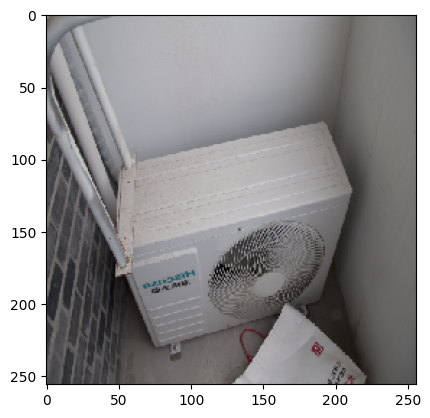

In [ ]:
plt.imshow(clean_batch[15])

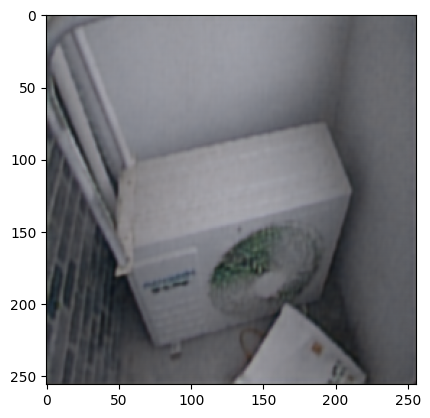

In [ ]:
plt.imshow(output_batch[15])

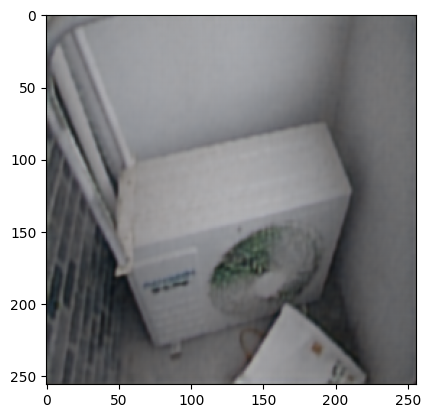

In [ ]:
plt.imshow(output_batch_1[15])

#Model Evaluation

In [ ]:
result_train=model_1.evaluate(train_generator,steps=65)

65/65 [==============================] - 53s 811ms/step - loss: 0.5321 - psnr: 23.4971 - mse: 0.0056 - mae: 0.0532


In [ ]:
#validation and test generator are same

result_test=model_1.evaluate(validation_generator,steps=17)

17/17 [==============================] - 16s 824ms/step - loss: 0.7606 - psnr: 21.7314 - mse: 0.0102 - mae: 0.0761
